# E-commerce Sentiment Analysis Robustness Tests

This notebook evaluates the robustness of our sentiment analysis model against various types of noisy inputs that might occur in real-world scenarios. We'll test how well the model handles:

1. Typographical errors (typos)
2. Truncated sentences 
3. Case sensitivity
4. Punctuation variations
5. Emoji and special characters

The goal is to understand how resilient our sentiment analysis API is against these common variations and identify any weaknesses that might need to be addressed.

## 1. Import Required Libraries

Let's start by importing all the necessary libraries we'll need for our robustness testing:

In [ ]:
import requests
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import re
from typing import Dict, List, Any, Tuple, Optional
from tqdm.notebook import tqdm

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# For reproducibility
random.seed(42)
np.random.seed(42)

## 2. Define Test Environment Variables

Next, we'll set up the constants and test data we'll need for our evaluations:

In [2]:
# API endpoints
INFERENCE_URL = "http://localhost:8004"
ANALYZE_ENDPOINT = f"{INFERENCE_URL}/analyze"
HEALTH_ENDPOINT = f"{INFERENCE_URL}/health"
TIMEOUT = 10  # seconds

# Test configuration
MAX_RETRIES = 3
LATENCY_THRESHOLD = 2.0  # seconds

# Baseline clean reviews with known sentiments
BASELINE_REVIEWS = [
    {
        "text": "This product exceeded all my expectations! The quality is outstanding.",
        "expected_sentiment": "positive"
    },
    {
        "text": "I absolutely love this item. Best purchase I've made all year!",
        "expected_sentiment": "positive"
    },
    {
        "text": "Works as advertised. Nothing special but does the job.",
        "expected_sentiment": "neutral"
    },
    {
        "text": "The product is okay I guess. Shipping was fast at least.",
        "expected_sentiment": "neutral"
    },
    {
        "text": "Not worth the price. I'm a bit disappointed with the purchase.",
        "expected_sentiment": "negative"
    },
    {
        "text": "Terrible quality. It broke after just two uses. Would not recommend.",
        "expected_sentiment": "negative"
    },
    {
        "text": "This could have been better, but it's not the worst I've seen.",
        "expected_sentiment": "neutral"
    },
    {
        "text": "Fantastic product, I've already ordered three more for my family!",
        "expected_sentiment": "positive"
    },
    {
        "text": "Complete waste of money. Customer service refused to help with return.",
        "expected_sentiment": "negative"
    },
    {
        "text": "The design is beautiful but functionality is lacking.",
        "expected_sentiment": "neutral"
    },
]

# Sentiment label mapping
LABEL_MAP = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive",
    "negative": "negative",
    "neutral": "neutral",
    "positive": "positive"
}

# Noise levels for testing
NOISE_LEVELS = {
    "low": 0.1,      # 10% of characters/words affected
    "medium": 0.25,  # 25% of characters/words affected
    "high": 0.5      # 50% of characters/words affected
}

# Check if the service is running
try:
    response = requests.get(HEALTH_ENDPOINT, timeout=TIMEOUT)
    if response.status_code == 200:
        print(f"✅ Inference service is running at {INFERENCE_URL}")
    else:
        print(f"⚠️ Inference service returned status code {response.status_code}")
except requests.exceptions.RequestException as e:
    print(f"❌ Could not connect to inference service: {e}")
    print(f"Please make sure the inference service is running at {INFERENCE_URL}")

✅ Inference service is running at http://localhost:8004


## 3. Helper Functions for API Requests

Let's create some utility functions for making API calls, measuring performance, and normalizing results:

In [3]:
def analyze_sentiment(text: str, retries: int = MAX_RETRIES) -> Tuple[Dict[str, Any], float]:
    """
    Send a request to the sentiment analysis API and measure response time.
    
    Args:
        text: The text to analyze
        retries: Number of retry attempts on failure
        
    Returns:
        Tuple of (API response as dict, response time in seconds)
    """
    payload = {"query_text": text}
    
    for attempt in range(retries):
        try:
            # Record start time
            start_time = time.time()
            
            # Make request
            response = requests.post(ANALYZE_ENDPOINT, json=payload, timeout=TIMEOUT)
            
            # Calculate latency
            latency = time.time() - start_time
            
            # Check response status code
            if response.status_code == 200:
                return response.json(), latency
            else:
                print(f"Attempt {attempt+1}/{retries}: API returned status code {response.status_code}")
        
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1}/{retries}: Request failed: {e}")
            
        # Wait before retrying (exponential backoff)
        if attempt < retries - 1:
            time.sleep(2 ** attempt)
    
    # If all retries fail, return empty result
    return {"error": "All API requests failed"}, 0.0

def normalize_sentiment(sentiment: str) -> str:
    """
    Normalize sentiment labels to consistent format.
    
    Args:
        sentiment: Raw sentiment label from API
        
    Returns:
        Normalized sentiment label
    """
    # Convert to lowercase
    sentiment_lower = sentiment.lower()
    
    # Check if it's a LABEL_X format
    if sentiment_lower.startswith("label_"):
        label_num = sentiment_lower.split("_")[1]
        if label_num == "0":
            return "negative"
        elif label_num == "1":
            return "neutral"
        elif label_num == "2":
            return "positive"
    
    # Otherwise use mapping or return as is
    return LABEL_MAP.get(sentiment_lower, sentiment_lower)

def evaluate_sentiment_accuracy(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Calculate accuracy metrics from sentiment analysis results.
    
    Args:
        results: List of result objects with expected and actual sentiments
        
    Returns:
        Dict of accuracy metrics
    """
    total = len(results)
    correct = sum(1 for r in results if r["correct"])
    accuracy = correct / total if total > 0 else 0
    
    # Calculate per-class metrics
    class_metrics = {}
    for sentiment in ["positive", "neutral", "negative"]:
        class_samples = [r for r in results if r["expected"] == sentiment]
        class_correct = sum(1 for r in class_samples if r["correct"])
        class_total = len(class_samples)
        
        class_metrics[sentiment] = {
            "accuracy": class_correct / class_total if class_total > 0 else 0,
            "total": class_total,
            "correct": class_correct
        }
    
    # Calculate average latency
    avg_latency = sum(r["latency"] for r in results) / total if total > 0 else 0
    
    # Calculate average confidence
    avg_confidence = sum(r["confidence"] for r in results) / total if total > 0 else 0
    
    return {
        "accuracy": accuracy,
        "total": total,
        "correct": correct,
        "avg_latency": avg_latency,
        "avg_confidence": avg_confidence,
        "class_metrics": class_metrics
    }

def run_baseline_evaluation() -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
    """
    Run sentiment analysis on baseline reviews to establish performance baseline.
    
    Returns:
        Tuple of (individual results, aggregated metrics)
    """
    print("Running baseline evaluation...")
    results = []
    
    for i, sample in enumerate(tqdm(BASELINE_REVIEWS)):
        # Call API
        result, latency = analyze_sentiment(sample["text"])
        
        # Check if API call was successful
        if "error" in result:
            print(f"Error analyzing sample {i+1}")
            continue
        
        # Extract and normalize sentiment
        raw_sentiment = result.get("sentiment", "")
        normalized_sentiment = normalize_sentiment(raw_sentiment)
        expected_sentiment = sample["expected_sentiment"]
        
        # Calculate correctness
        correct = normalized_sentiment == expected_sentiment
        
        # Store result
        results.append({
            "sample": i + 1,
            "text": sample["text"],
            "expected": expected_sentiment,
            "raw_sentiment": raw_sentiment,
            "actual": normalized_sentiment,
            "confidence": result.get("confidence", 0),
            "correct": correct,
            "latency": latency
        })
    
    # Calculate accuracy metrics
    metrics = evaluate_sentiment_accuracy(results)
    
    print(f"\nBaseline Results:")
    print(f"Overall Accuracy: {metrics['accuracy']:.2%} ({metrics['correct']}/{metrics['total']})")
    print(f"Average Latency: {metrics['avg_latency']:.3f} seconds")
    print(f"Average Confidence: {metrics['avg_confidence']:.3f}")
    
    # Print class-specific metrics
    for sentiment, class_metric in metrics["class_metrics"].items():
        print(f"{sentiment.capitalize()}: {class_metric['accuracy']:.2%} "
              f"({class_metric['correct']}/{class_metric['total']})")
    
    return results, metrics

## 4. Generate Test Cases with Noise

Now let's create functions to generate different types of noisy inputs:

In [4]:
def add_typos(text: str, error_rate: float = 0.1) -> str:
    """
    Add random typos to text by replacing characters with adjacent keyboard keys.
    
    Args:
        text: Original text
        error_rate: Proportion of characters to modify (0.0-1.0)
        
    Returns:
        Text with typos
    """
    if error_rate <= 0:
        return text
        
    # Common keyboard adjacency map (QWERTY layout)
    adjacency_map = {
        'a': 'sqzw', 'b': 'vghn', 'c': 'xdfv', 'd': 'sfxce', 'e': 'wrsdf', 'f': 'drtgvc',
        'g': 'ftyhbv', 'h': 'gyujnb', 'i': 'ujklo', 'j': 'huikmn', 'k': 'jiolm',
        'l': 'kop;', 'm': 'njk,', 'n': 'bhjm', 'o': 'iklp', 'p': 'ol[', 'q': 'wa',
        'r': 'etdf', 's': 'awedxz', 't': 'rfgy', 'u': 'yhji', 'v': 'cfgb',
        'w': 'qase', 'x': 'zsdc', 'y': 'tghu', 'z': 'asx'
    }
    
    result = list(text)
    chars_to_modify = int(len(text) * error_rate)
    
    # Select random positions to modify
    positions = random.sample(range(len(text)), min(chars_to_modify, len(text)))
    
    for pos in positions:
        char = text[pos].lower()
        
        # Skip spaces and special characters
        if char not in adjacency_map:
            continue
            
        # Choose a random adjacent key
        adjacent_chars = adjacency_map[char]
        if adjacent_chars:
            replacement = random.choice(adjacent_chars)
            
            # Preserve original case
            if text[pos].isupper():
                replacement = replacement.upper()
                
            result[pos] = replacement
    
    return ''.join(result)

def truncate_text(text: str, truncation_point: float = 0.5) -> str:
    """
    Truncate text at a specified point.
    
    Args:
        text: Original text
        truncation_point: Position to truncate at (0.0-1.0)
        
    Returns:
        Truncated text
    """
    if truncation_point >= 1.0:
        return text
        
    # Calculate truncation index
    truncation_index = int(len(text) * truncation_point)
    
    # Ensure we don't truncate to an empty string
    truncation_index = max(truncation_index, 1)
    
    return text[:truncation_index]

def change_case(text: str, case_type: str = 'random') -> str:
    """
    Modify text case according to specified type.
    
    Args:
        text: Original text
        case_type: Type of case modification ('upper', 'lower', 'title', 'random')
        
    Returns:
        Text with modified case
    """
    if case_type == 'upper':
        return text.upper()
    elif case_type == 'lower':
        return text.lower()
    elif case_type == 'title':
        return text.title()
    elif case_type == 'random':
        result = []
        for char in text:
            if random.random() < 0.5:
                result.append(char.upper())
            else:
                result.append(char.lower())
        return ''.join(result)
    else:
        return text

def modify_punctuation(text: str, modification: str = 'remove', intensity: float = 0.5) -> str:
    """
    Modify punctuation in text.
    
    Args:
        text: Original text
        modification: Type of modification ('remove', 'add', 'replace')
        intensity: Intensity of modification (0.0-1.0)
        
    Returns:
        Text with modified punctuation
    """
    punctuation_chars = string.punctuation
    
    if modification == 'remove':
        # Remove a portion of punctuation
        result = list(text)
        punctuation_positions = [i for i, char in enumerate(text) if char in punctuation_chars]
        
        # Determine how many punctuation marks to remove
        num_to_remove = int(len(punctuation_positions) * intensity)
        if num_to_remove == 0 and punctuation_positions:
            num_to_remove = 1
            
        # Select positions to remove
        remove_positions = random.sample(punctuation_positions, min(num_to_remove, len(punctuation_positions)))
        
        for pos in sorted(remove_positions, reverse=True):
            result.pop(pos)
            
        return ''.join(result)
        
    elif modification == 'add':
        # Add extra punctuation
        result = list(text)
        non_punct_positions = [i for i, char in enumerate(text) if char not in punctuation_chars and not char.isspace()]
        
        # Determine how many punctuation marks to add
        num_to_add = int(len(non_punct_positions) * intensity)
        if num_to_add == 0 and non_punct_positions:
            num_to_add = 1
            
        # Select positions to add punctuation
        add_positions = random.sample(non_punct_positions, min(num_to_add, len(non_punct_positions)))
        
        # Add random punctuation at selected positions
        offset = 0
        for pos in sorted(add_positions):
            punct = random.choice(punctuation_chars)
            result.insert(pos + offset, punct)
            offset += 1
            
        return ''.join(result)
        
    elif modification == 'replace':
        # Replace existing punctuation with different punctuation
        result = list(text)
        punctuation_positions = [i for i, char in enumerate(text) if char in punctuation_chars]
        
        # Determine how many punctuation marks to replace
        num_to_replace = int(len(punctuation_positions) * intensity)
        if num_to_replace == 0 and punctuation_positions:
            num_to_replace = 1
            
        # Select positions to replace
        replace_positions = random.sample(punctuation_positions, min(num_to_replace, len(punctuation_positions)))
        
        for pos in replace_positions:
            # Choose a different punctuation mark
            original = text[pos]
            options = [p for p in punctuation_chars if p != original]
            if options:
                result[pos] = random.choice(options)
                
        return ''.join(result)
        
    else:
        return text

def add_special_chars_emojis(text: str, num_to_add: int = 2) -> str:
    """
    Add special characters and emoji-like symbols to text.
    
    Args:
        text: Original text
        num_to_add: Number of special chars/emojis to add
        
    Returns:
        Text with added special characters
    """
    # Simple emoji-like symbols
    emojis = ["😀", "😊", "👍", "❤️", "⭐", "🔥", "👏", "🙌", "🎉", "✅", "❌", "⚠️"]
    
    result = list(text)
    positions = random.sample(range(len(text) + 1), min(num_to_add, len(text) + 1))
    
    # Add emojis at selected positions
    offset = 0
    for pos in sorted(positions):
        emoji = random.choice(emojis)
        result.insert(pos + offset, emoji)
        offset += 1
        
    return ''.join(result)

def generate_noisy_variants(review: Dict[str, str]) -> Dict[str, Dict[str, str]]:
    """
    Generate various noisy variants of a review text.
    
    Args:
        review: Original review dictionary with text and expected sentiment
        
    Returns:
        Dictionary of noisy variants
    """
    original_text = review["text"]
    expected_sentiment = review["expected_sentiment"]
    
    variants = {
        "original": {
            "text": original_text,
            "expected_sentiment": expected_sentiment
        }
    }
    
    # Add typo variants
    for level, rate in NOISE_LEVELS.items():
        variants[f"typos_{level}"] = {
            "text": add_typos(original_text, rate),
            "expected_sentiment": expected_sentiment
        }
    
    # Add truncation variants
    truncation_points = [0.25, 0.5, 0.75]
    for point in truncation_points:
        variants[f"truncated_{int(point*100)}"] = {
            "text": truncate_text(original_text, point),
            "expected_sentiment": expected_sentiment
        }
    
    # Add case variants
    for case in ["upper", "lower", "title", "random"]:
        variants[f"case_{case}"] = {
            "text": change_case(original_text, case),
            "expected_sentiment": expected_sentiment
        }
    
    # Add punctuation variants
    for mod in ["remove", "add", "replace"]:
        for level, intensity in NOISE_LEVELS.items():
            variants[f"punct_{mod}_{level}"] = {
                "text": modify_punctuation(original_text, mod, intensity),
                "expected_sentiment": expected_sentiment
            }
    
    # Add emojis
    variants["with_emojis"] = {
        "text": add_special_chars_emojis(original_text),
        "expected_sentiment": expected_sentiment
    }
    
    return variants

Let's start by running the baseline evaluation to establish our performance benchmark:

In [5]:
# Run baseline evaluation
baseline_results, baseline_metrics = run_baseline_evaluation()

Running baseline evaluation...


  0%|          | 0/10 [00:00<?, ?it/s]


Baseline Results:
Overall Accuracy: 60.00% (6/10)
Average Latency: 0.076 seconds
Average Confidence: 0.996
Positive: 100.00% (3/3)
Neutral: 0.00% (0/4)
Negative: 100.00% (3/3)


## 5. Test Typo Robustness

Let's evaluate how the sentiment model performs when input text contains common typographical errors of varying severity levels.

Testing robustness to typos...


Typos (low):   0%|          | 0/10 [00:00<?, ?it/s]


Typo Level - LOW (error rate: 10%):
Accuracy: 60.00% (6/10)
Avg Confidence: 0.987


Typos (medium):   0%|          | 0/10 [00:00<?, ?it/s]


Typo Level - MEDIUM (error rate: 25%):
Accuracy: 50.00% (5/10)
Avg Confidence: 0.866


Typos (high):   0%|          | 0/10 [00:00<?, ?it/s]


Typo Level - HIGH (error rate: 50%):
Accuracy: 30.00% (3/10)
Avg Confidence: 0.790


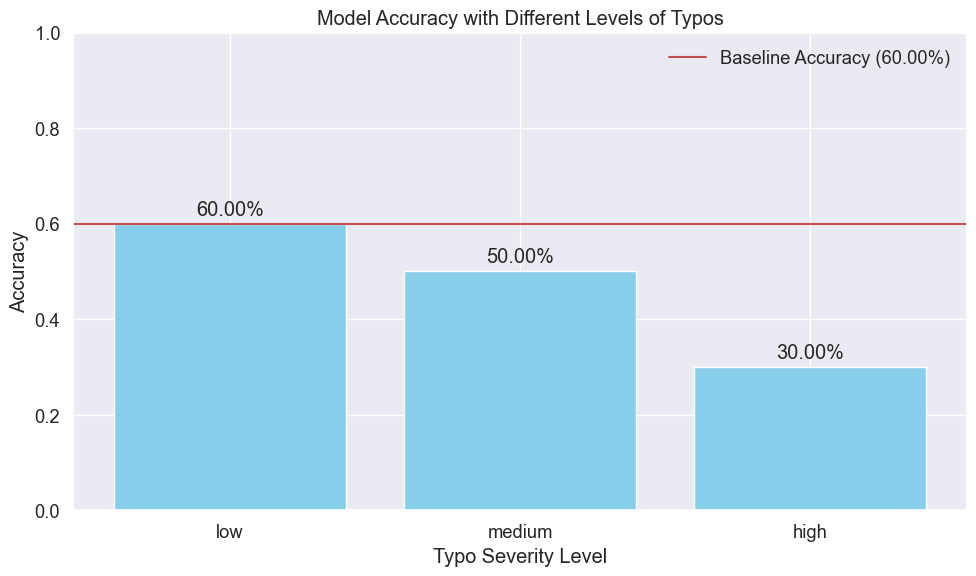

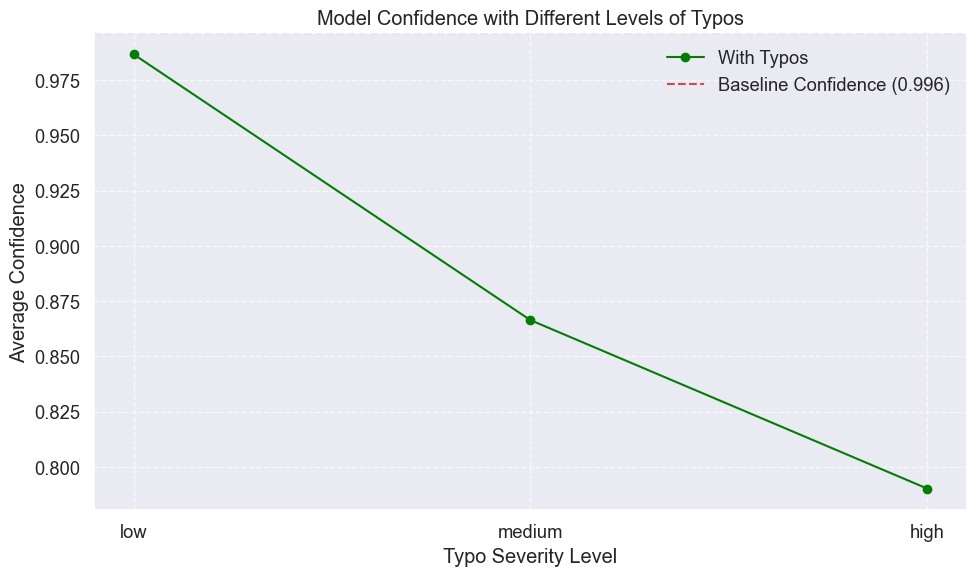


Examples of typo errors that changed the sentiment prediction:

LOW typo level - Example error:
Original: "This could have been better, but it's not the worst I've seen."
With typos: "This could have been begter, hut it's nof the worst I've swen."
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 1.00)

MEDIUM typo level - Example error:
Original: "The product is okay I guess. Shipping was fast at least."
With typos: "Yge orosuct is kkay I guess. Shipoijg was fasg qt lwast."
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 0.56)

HIGH typo level - Example error:
Original: "Complete waste of money. Customer service refused to help with return."
With typos: "Comokfrs qaste pf mpney. Dhzfomse swtfkvr rffjsed ti ueop wlty rwturn."
Expected sentiment: negative
Predicted sentiment: positive (confidence: 0.71)


In [6]:
def test_typo_robustness():
    """Test model performance with various levels of typographical errors."""
    print("Testing robustness to typos...")
    
    typo_results = {}
    
    # For each noise level
    for level, rate in NOISE_LEVELS.items():
        level_results = []
        
        # Process each baseline review
        for review in tqdm(BASELINE_REVIEWS, desc=f"Typos ({level})"):
            # Generate text with typos
            text_with_typos = add_typos(review["text"], rate)
            
            # Call API
            result, latency = analyze_sentiment(text_with_typos)
            
            # Check if API call was successful
            if "error" in result:
                continue
            
            # Extract and normalize sentiment
            raw_sentiment = result.get("sentiment", "")
            normalized_sentiment = normalize_sentiment(raw_sentiment)
            expected_sentiment = review["expected_sentiment"]
            
            # Calculate correctness
            correct = normalized_sentiment == expected_sentiment
            
            # Store result
            level_results.append({
                "text": text_with_typos,
                "original": review["text"],
                "expected": expected_sentiment,
                "raw_sentiment": raw_sentiment,
                "actual": normalized_sentiment,
                "confidence": result.get("confidence", 0),
                "correct": correct,
                "latency": latency
            })
        
        # Calculate metrics for this noise level
        metrics = evaluate_sentiment_accuracy(level_results)
        typo_results[level] = {
            "results": level_results,
            "metrics": metrics
        }
        
        print(f"\nTypo Level - {level.upper()} (error rate: {rate*100:.0f}%):")
        print(f"Accuracy: {metrics['accuracy']:.2%} ({metrics['correct']}/{metrics['total']})")
        print(f"Avg Confidence: {metrics['avg_confidence']:.3f}")
    
    return typo_results

# Run the typo robustness test
typo_test_results = test_typo_robustness()

# Prepare data for visualization
typo_levels = list(typo_test_results.keys())
typo_accuracies = [typo_test_results[level]["metrics"]["accuracy"] for level in typo_levels]
typo_confidences = [typo_test_results[level]["metrics"]["avg_confidence"] for level in typo_levels]
baseline_accuracy = baseline_metrics["accuracy"]

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar(typo_levels, typo_accuracies, color='skyblue')
plt.axhline(y=baseline_accuracy, color='r', linestyle='-', label=f'Baseline Accuracy ({baseline_accuracy:.2%})')
plt.xlabel('Typo Severity Level')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Different Levels of Typos')
plt.ylim(0, 1.0)

# Add baseline marker
plt.legend()

# Add values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot confidence changes
plt.figure(figsize=(10, 6))
plt.plot(typo_levels, typo_confidences, marker='o', linestyle='-', color='green', label='With Typos')
plt.axhline(y=baseline_metrics["avg_confidence"], color='r', linestyle='--', 
            label=f'Baseline Confidence ({baseline_metrics["avg_confidence"]:.3f})')
plt.xlabel('Typo Severity Level')
plt.ylabel('Average Confidence')
plt.title('Model Confidence with Different Levels of Typos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Show examples of typo errors
print("\nExamples of typo errors that changed the sentiment prediction:")
for level, data in typo_test_results.items():
    errors = [r for r in data["results"] if not r["correct"]]
    if errors:
        print(f"\n{level.upper()} typo level - Example error:")
        example = random.choice(errors)
        print(f"Original: \"{example['original']}\"")
        print(f"With typos: \"{example['text']}\"")
        print(f"Expected sentiment: {example['expected']}")
        print(f"Predicted sentiment: {example['actual']} (confidence: {example['confidence']:.2f})")
    else:
        print(f"\n{level.upper()} typo level - No errors")

## 6. Test Truncation Robustness

Let's evaluate how the model performs when sentences are truncated at different points:

Testing robustness to text truncation...


Truncation (25%):   0%|          | 0/10 [00:00<?, ?it/s]


Truncation Level - 25%:
Accuracy: 30.00% (3/10)
Avg Confidence: 0.741


Truncation (50%):   0%|          | 0/10 [00:00<?, ?it/s]


Truncation Level - 50%:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.951


Truncation (75%):   0%|          | 0/10 [00:00<?, ?it/s]


Truncation Level - 75%:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.989


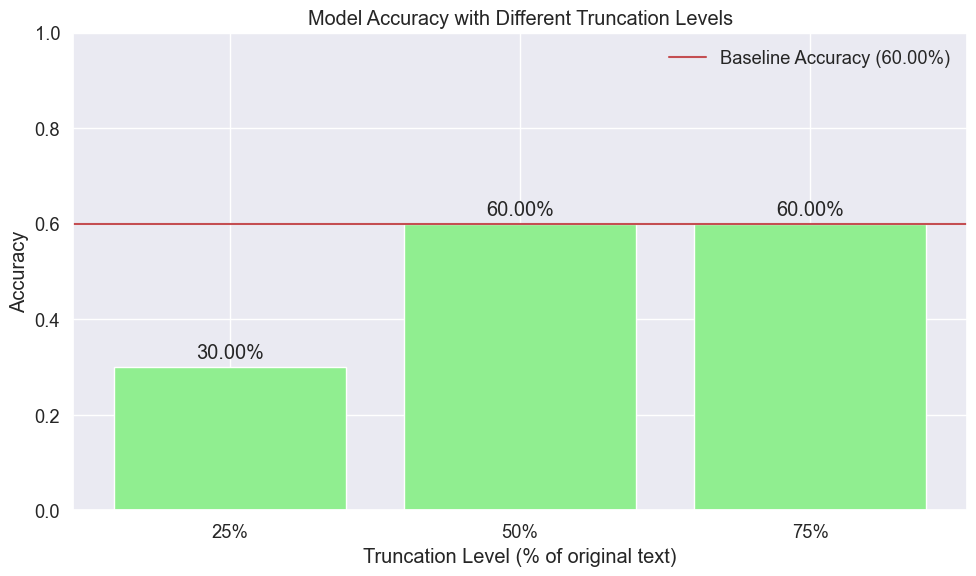

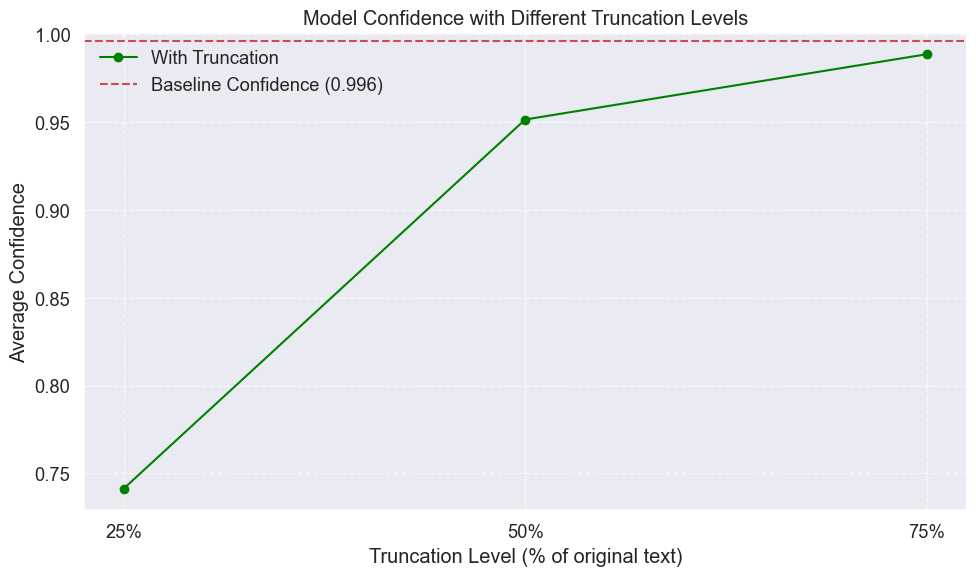


Examples of truncation errors that changed the sentiment prediction:

25% truncation level - Example error:
Original: "This product exceeded all my expectations! The quality is outstanding."
Truncated: "This product exce"
Expected sentiment: positive
Predicted sentiment: negative (confidence: 0.60)

50% truncation level - Example error:
Original: "The product is okay I guess. Shipping was fast at least."
Truncated: "The product is okay I guess."
Expected sentiment: neutral
Predicted sentiment: positive (confidence: 0.99)

75% truncation level - Example error:
Original: "This could have been better, but it's not the worst I've seen."
Truncated: "This could have been better, but it's not the "
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 0.99)


In [7]:
def test_truncation_robustness():
    """Test model performance with truncated reviews at different points."""
    print("Testing robustness to text truncation...")
    
    # Truncation points to test (percentage of original text)
    truncation_points = [0.25, 0.5, 0.75]
    truncation_results = {}
    
    # For each truncation point
    for point in truncation_points:
        point_label = f"{int(point*100)}%"
        level_results = []
        
        # Process each baseline review
        for review in tqdm(BASELINE_REVIEWS, desc=f"Truncation ({point_label})"):
            # Generate truncated text
            truncated_text = truncate_text(review["text"], point)
            
            # Call API
            result, latency = analyze_sentiment(truncated_text)
            
            # Check if API call was successful
            if "error" in result:
                continue
            
            # Extract and normalize sentiment
            raw_sentiment = result.get("sentiment", "")
            normalized_sentiment = normalize_sentiment(raw_sentiment)
            expected_sentiment = review["expected_sentiment"]
            
            # Calculate correctness
            correct = normalized_sentiment == expected_sentiment
            
            # Store result
            level_results.append({
                "text": truncated_text,
                "original": review["text"],
                "expected": expected_sentiment,
                "raw_sentiment": raw_sentiment,
                "actual": normalized_sentiment,
                "confidence": result.get("confidence", 0),
                "correct": correct,
                "latency": latency,
                "truncation_point": point
            })
        
        # Calculate metrics for this truncation level
        metrics = evaluate_sentiment_accuracy(level_results)
        truncation_results[point_label] = {
            "results": level_results,
            "metrics": metrics
        }
        
        print(f"\nTruncation Level - {point_label}:")
        print(f"Accuracy: {metrics['accuracy']:.2%} ({metrics['correct']}/{metrics['total']})")
        print(f"Avg Confidence: {metrics['avg_confidence']:.3f}")
    
    return truncation_results

# Run the truncation robustness test
truncation_test_results = test_truncation_robustness()

# Prepare data for visualization
truncation_levels = list(truncation_test_results.keys())
truncation_accuracies = [truncation_test_results[level]["metrics"]["accuracy"] for level in truncation_levels]
truncation_confidences = [truncation_test_results[level]["metrics"]["avg_confidence"] for level in truncation_levels]

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar(truncation_levels, truncation_accuracies, color='lightgreen')
plt.axhline(y=baseline_metrics["accuracy"], color='r', linestyle='-', 
           label=f'Baseline Accuracy ({baseline_metrics["accuracy"]:.2%})')
plt.xlabel('Truncation Level (% of original text)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Different Truncation Levels')
plt.ylim(0, 1.0)

# Add baseline marker
plt.legend()

# Add values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot confidence changes
plt.figure(figsize=(10, 6))
plt.plot(truncation_levels, truncation_confidences, marker='o', linestyle='-', color='green', label='With Truncation')
plt.axhline(y=baseline_metrics["avg_confidence"], color='r', linestyle='--', 
            label=f'Baseline Confidence ({baseline_metrics["avg_confidence"]:.3f})')
plt.xlabel('Truncation Level (% of original text)')
plt.ylabel('Average Confidence')
plt.title('Model Confidence with Different Truncation Levels')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Show examples of truncated text errors
print("\nExamples of truncation errors that changed the sentiment prediction:")
for level, data in truncation_test_results.items():
    errors = [r for r in data["results"] if not r["correct"]]
    if errors:
        print(f"\n{level} truncation level - Example error:")
        example = random.choice(errors)
        print(f"Original: \"{example['original']}\"")
        print(f"Truncated: \"{example['text']}\"")
        print(f"Expected sentiment: {example['expected']}")
        print(f"Predicted sentiment: {example['actual']} (confidence: {example['confidence']:.2f})")
    else:
        print(f"\n{level} truncation level - No errors")

## 7. Test Case Sensitivity

Let's evaluate how changes in capitalization patterns affect sentiment predictions:

Testing robustness to case variations...


Case (upper):   0%|          | 0/10 [00:00<?, ?it/s]


Case Type - upper:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.996


Case (lower):   0%|          | 0/10 [00:00<?, ?it/s]


Case Type - lower:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.996


Case (title):   0%|          | 0/10 [00:00<?, ?it/s]


Case Type - title:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.996


Case (random):   0%|          | 0/10 [00:00<?, ?it/s]


Case Type - random:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.996


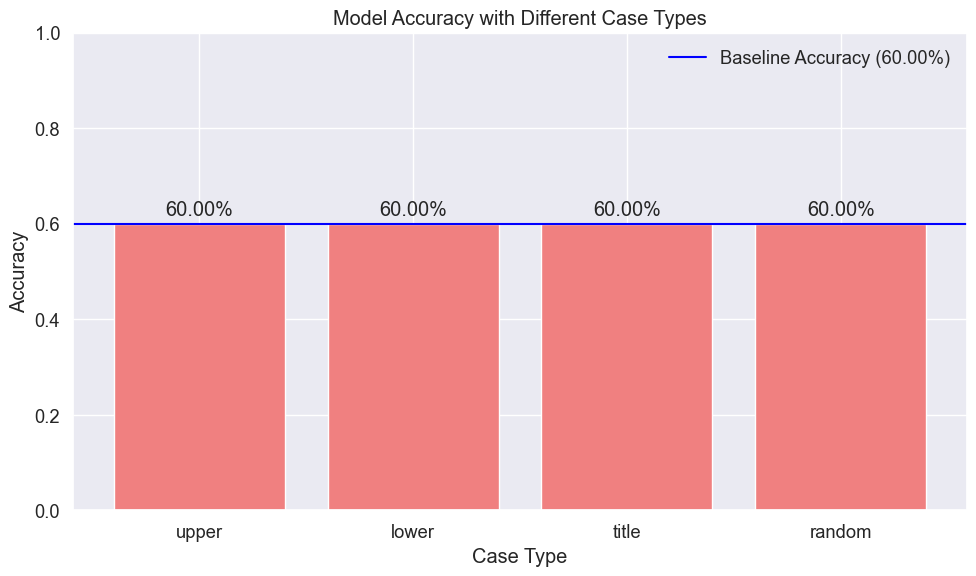

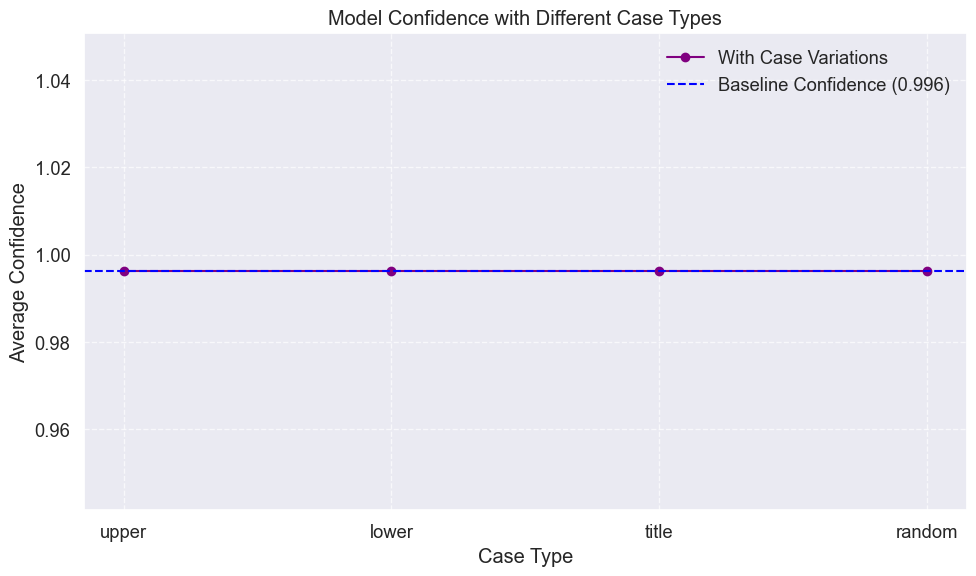


Examples of case variations that changed the sentiment prediction:

UPPER case - Example error:
Original: "The product is okay I guess. Shipping was fast at least."
Modified: "THE PRODUCT IS OKAY I GUESS. SHIPPING WAS FAST AT LEAST."
Expected sentiment: neutral
Predicted sentiment: positive (confidence: 0.99)

LOWER case - Example error:
Original: "This could have been better, but it's not the worst I've seen."
Modified: "this could have been better, but it's not the worst i've seen."
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 1.00)

TITLE case - Example error:
Original: "The design is beautiful but functionality is lacking."
Modified: "The Design Is Beautiful But Functionality Is Lacking."
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 1.00)

RANDOM case - Example error:
Original: "The product is okay I guess. Shipping was fast at least."
Modified: "ThE ProDuCT is okAY I gUesS. SHiPPiNg waS faSt AT lEAsT."
Expected sentiment: neutra

In [8]:
def test_case_sensitivity():
    """Test model performance with different text case patterns."""
    print("Testing robustness to case variations...")
    
    # Case variations to test
    case_types = ["upper", "lower", "title", "random"]
    case_results = {}
    
    # For each case type
    for case_type in case_types:
        case_results_list = []
        
        # Process each baseline review
        for review in tqdm(BASELINE_REVIEWS, desc=f"Case ({case_type})"):
            # Generate text with modified case
            modified_text = change_case(review["text"], case_type)
            
            # Call API
            result, latency = analyze_sentiment(modified_text)
            
            # Check if API call was successful
            if "error" in result:
                continue
            
            # Extract and normalize sentiment
            raw_sentiment = result.get("sentiment", "")
            normalized_sentiment = normalize_sentiment(raw_sentiment)
            expected_sentiment = review["expected_sentiment"]
            
            # Calculate correctness
            correct = normalized_sentiment == expected_sentiment
            
            # Store result
            case_results_list.append({
                "text": modified_text,
                "original": review["text"],
                "expected": expected_sentiment,
                "raw_sentiment": raw_sentiment,
                "actual": normalized_sentiment,
                "confidence": result.get("confidence", 0),
                "correct": correct,
                "latency": latency,
                "case_type": case_type
            })
        
        # Calculate metrics for this case type
        metrics = evaluate_sentiment_accuracy(case_results_list)
        case_results[case_type] = {
            "results": case_results_list,
            "metrics": metrics
        }
        
        print(f"\nCase Type - {case_type}:")
        print(f"Accuracy: {metrics['accuracy']:.2%} ({metrics['correct']}/{metrics['total']})")
        print(f"Avg Confidence: {metrics['avg_confidence']:.3f}")
    
    return case_results

# Run the case sensitivity test
case_test_results = test_case_sensitivity()

# Prepare data for visualization
case_types = list(case_test_results.keys())
case_accuracies = [case_test_results[case_type]["metrics"]["accuracy"] for case_type in case_types]
case_confidences = [case_test_results[case_type]["metrics"]["avg_confidence"] for case_type in case_types]

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar(case_types, case_accuracies, color='lightcoral')
plt.axhline(y=baseline_metrics["accuracy"], color='blue', linestyle='-', 
           label=f'Baseline Accuracy ({baseline_metrics["accuracy"]:.2%})')
plt.xlabel('Case Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Different Case Types')
plt.ylim(0, 1.0)

# Add baseline marker
plt.legend()

# Add values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot confidence changes
plt.figure(figsize=(10, 6))
plt.plot(case_types, case_confidences, marker='o', linestyle='-', color='purple', label='With Case Variations')
plt.axhline(y=baseline_metrics["avg_confidence"], color='blue', linestyle='--', 
            label=f'Baseline Confidence ({baseline_metrics["avg_confidence"]:.3f})')
plt.xlabel('Case Type')
plt.ylabel('Average Confidence')
plt.title('Model Confidence with Different Case Types')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Show examples of case variation errors
print("\nExamples of case variations that changed the sentiment prediction:")
for case_type, data in case_test_results.items():
    errors = [r for r in data["results"] if not r["correct"]]
    if errors:
        print(f"\n{case_type.upper()} case - Example error:")
        example = random.choice(errors)
        print(f"Original: \"{example['original']}\"")
        print(f"Modified: \"{example['text']}\"")
        print(f"Expected sentiment: {example['expected']}")
        print(f"Predicted sentiment: {example['actual']} (confidence: {example['confidence']:.2f})")
    else:
        print(f"\n{case_type.upper()} case - No errors")

## 8. Test Punctuation Variations

Let's evaluate how the model handles modifications to punctuation:

Testing robustness to punctuation variations...


Punct (remove - low):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - REMOVE (low):
Accuracy: 60.00% (6/10)
Avg Confidence: 0.983


Punct (remove - medium):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - REMOVE (medium):
Accuracy: 60.00% (6/10)
Avg Confidence: 0.983


Punct (remove - high):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - REMOVE (high):
Accuracy: 60.00% (6/10)
Avg Confidence: 0.996


Punct (add - low):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - ADD (low):
Accuracy: 50.00% (5/10)
Avg Confidence: 0.962


Punct (add - medium):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - ADD (medium):
Accuracy: 40.00% (4/10)
Avg Confidence: 0.944


Punct (add - high):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - ADD (high):
Accuracy: 30.00% (3/10)
Avg Confidence: 0.882


Punct (replace - low):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - REPLACE (low):
Accuracy: 60.00% (6/10)
Avg Confidence: 0.996


Punct (replace - medium):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - REPLACE (medium):
Accuracy: 60.00% (6/10)
Avg Confidence: 0.972


Punct (replace - high):   0%|          | 0/10 [00:00<?, ?it/s]


Punctuation - REPLACE (high):
Accuracy: 60.00% (6/10)
Avg Confidence: 0.958


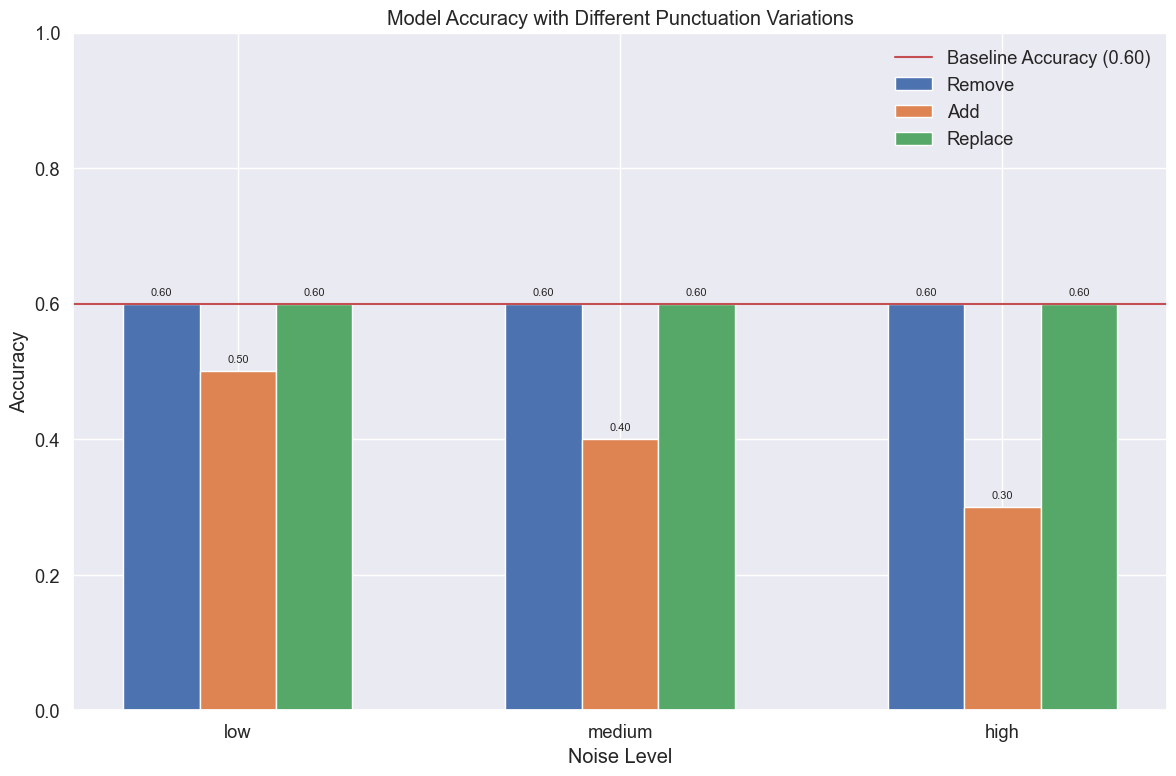

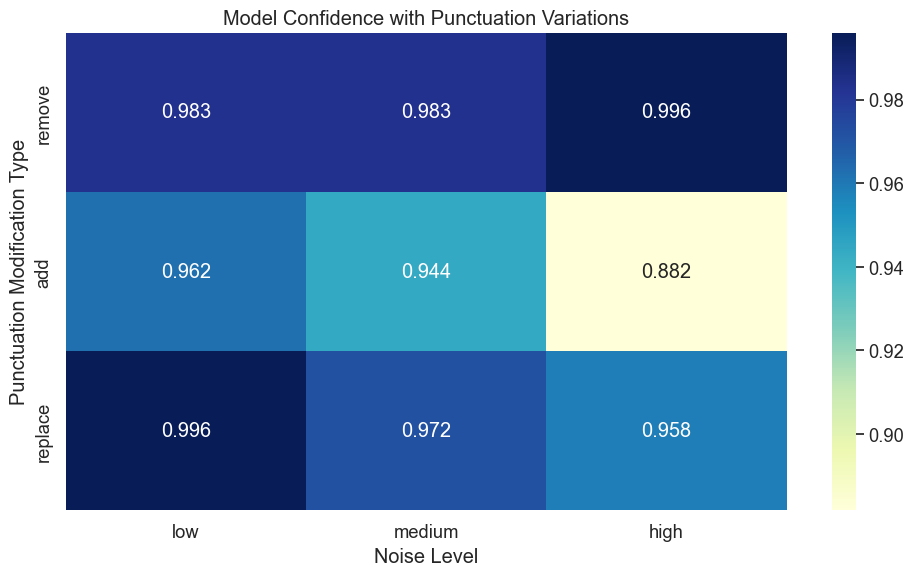


Examples of punctuation variations that changed the sentiment prediction:

REMOVE punctuation (low) - Example error:
Original: "This could have been better, but it's not the worst I've seen."
Modified: "This could have been better, but it's not the worst I've seen"
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 0.99)

REMOVE punctuation (medium) - Example error:
Original: "Works as advertised. Nothing special but does the job."
Modified: "Works as advertised Nothing special but does the job."
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 0.87)

REMOVE punctuation (high) - Example error:
Original: "Works as advertised. Nothing special but does the job."
Modified: "Works as advertised. Nothing special but does the job"
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 1.00)

ADD punctuation (low) - Example error:
Original: "Works as advertised. Nothing special but does the job."
Modified: "W:orks as advertised. Nothin

In [9]:
def test_punctuation_variations():
    """Test model performance with modified punctuation."""
    print("Testing robustness to punctuation variations...")
    
    # Punctuation modification types
    punct_mods = ["remove", "add", "replace"]
    punct_results = {}
    
    # For each punctuation modification type
    for mod in punct_mods:
        mod_results = {}
        
        # For each noise level
        for level, intensity in NOISE_LEVELS.items():
            key = f"{mod}_{level}"
            level_results = []
            
            # Process each baseline review
            for review in tqdm(BASELINE_REVIEWS, desc=f"Punct ({mod} - {level})"):
                # Generate text with modified punctuation
                modified_text = modify_punctuation(review["text"], mod, intensity)
                
                # Call API
                result, latency = analyze_sentiment(modified_text)
                
                # Check if API call was successful
                if "error" in result:
                    continue
                
                # Extract and normalize sentiment
                raw_sentiment = result.get("sentiment", "")
                normalized_sentiment = normalize_sentiment(raw_sentiment)
                expected_sentiment = review["expected_sentiment"]
                
                # Calculate correctness
                correct = normalized_sentiment == expected_sentiment
                
                # Store result
                level_results.append({
                    "text": modified_text,
                    "original": review["text"],
                    "expected": expected_sentiment,
                    "raw_sentiment": raw_sentiment,
                    "actual": normalized_sentiment,
                    "confidence": result.get("confidence", 0),
                    "correct": correct,
                    "latency": latency,
                    "punct_mod": mod,
                    "intensity": intensity
                })
            
            # Calculate metrics for this punctuation modification and intensity
            metrics = evaluate_sentiment_accuracy(level_results)
            mod_results[level] = {
                "results": level_results,
                "metrics": metrics
            }
            
            print(f"\nPunctuation - {mod.upper()} ({level}):")
            print(f"Accuracy: {metrics['accuracy']:.2%} ({metrics['correct']}/{metrics['total']})")
            print(f"Avg Confidence: {metrics['avg_confidence']:.3f}")
        
        punct_results[mod] = mod_results
    
    return punct_results

# Run the punctuation variation test
punct_test_results = test_punctuation_variations()

# Prepare data for comparative visualization
punct_types = list(punct_test_results.keys())
noise_levels = list(NOISE_LEVELS.keys())

# Create a grouped bar chart for punctuation variations
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2
index = np.arange(len(noise_levels))

for i, punct_type in enumerate(punct_types):
    accuracies = [punct_test_results[punct_type][level]["metrics"]["accuracy"] for level in noise_levels]
    offset = (i - len(punct_types)/2 + 0.5) * bar_width
    rect = ax.bar(index + offset, accuracies, bar_width, 
                  label=punct_type.capitalize())
    
    # Add values on bars
    for j, bar in enumerate(rect):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# Add baseline accuracy
ax.axhline(y=baseline_metrics["accuracy"], color='r', linestyle='-', 
           label=f'Baseline Accuracy ({baseline_metrics["accuracy"]:.2f})')

ax.set_xlabel('Noise Level')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy with Different Punctuation Variations')
ax.set_xticks(index)
ax.set_xticklabels(noise_levels)
ax.legend()
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

# Create a heat map for confidence values
confidence_data = np.zeros((len(punct_types), len(noise_levels)))
for i, punct_type in enumerate(punct_types):
    for j, level in enumerate(noise_levels):
        confidence_data[i, j] = punct_test_results[punct_type][level]["metrics"]["avg_confidence"]

plt.figure(figsize=(10, 6))
sns.heatmap(confidence_data, annot=True, cmap="YlGnBu", fmt=".3f",
            xticklabels=noise_levels, yticklabels=punct_types)
plt.title('Model Confidence with Punctuation Variations')
plt.xlabel('Noise Level')
plt.ylabel('Punctuation Modification Type')
plt.tight_layout()
plt.show()

# Show examples of punctuation variation errors
print("\nExamples of punctuation variations that changed the sentiment prediction:")
for punct_type in punct_types:
    for level in noise_levels:
        data = punct_test_results[punct_type][level]
        errors = [r for r in data["results"] if not r["correct"]]
        if errors:
            print(f"\n{punct_type.upper()} punctuation ({level}) - Example error:")
            example = random.choice(errors)
            print(f"Original: \"{example['original']}\"")
            print(f"Modified: \"{example['text']}\"")
            print(f"Expected sentiment: {example['expected']}")
            print(f"Predicted sentiment: {example['actual']} (confidence: {example['confidence']:.2f})")
        else:
            print(f"\n{punct_type.upper()} punctuation ({level}) - No errors")

## 9. Test Emoji and Special Character Handling

Finally, let's assess how the model handles text containing emojis and special characters:

Testing robustness to emojis and special characters...


Emojis (1):   0%|          | 0/10 [00:00<?, ?it/s]


Emoji Count - 1:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.996


Emojis (3):   0%|          | 0/10 [00:00<?, ?it/s]


Emoji Count - 3:
Accuracy: 50.00% (5/10)
Avg Confidence: 0.927


Emojis (5):   0%|          | 0/10 [00:00<?, ?it/s]


Emoji Count - 5:
Accuracy: 60.00% (6/10)
Avg Confidence: 0.923


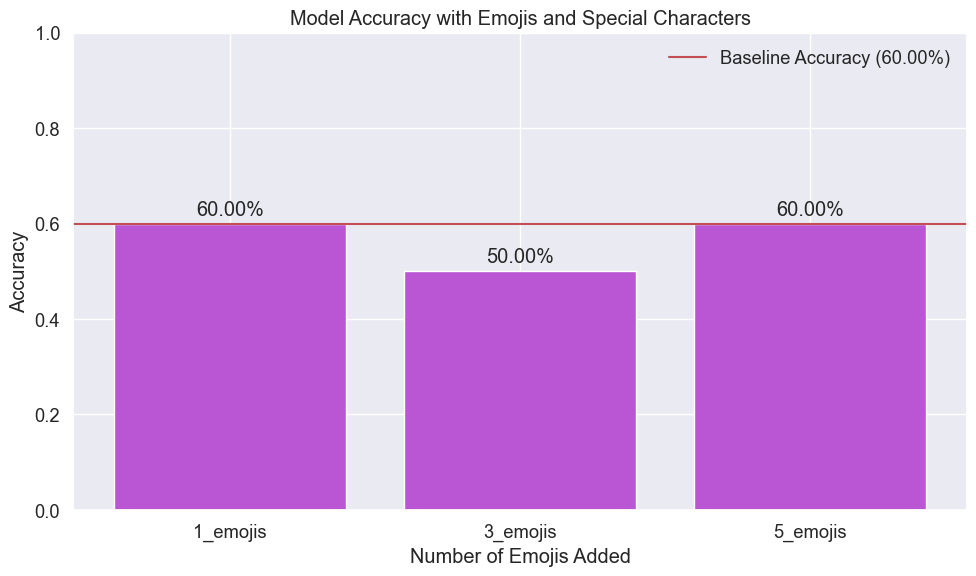

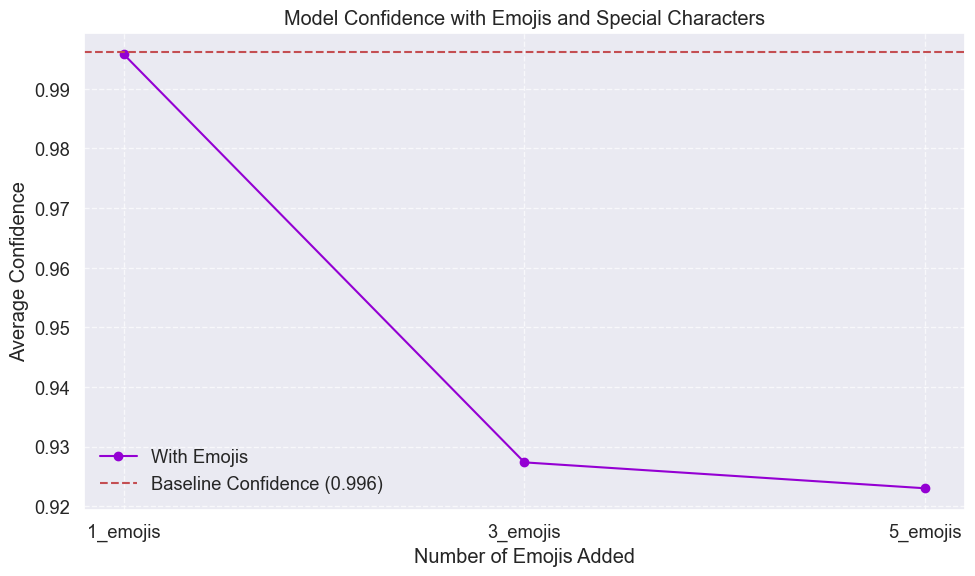


Examples of emoji additions that changed the sentiment prediction:

1_emojis - Example error:
Original: "Works as advertised. Nothing special but does the job."
With emojis: "Works as advertised. Nothing speci✅al but does the job."
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 1.00)

3_emojis - Example error:
Original: "This could have been better, but it's not the worst I've seen."
With emojis: "This could ✅have been better❌, but it's not t👏he worst I've seen."
Expected sentiment: neutral
Predicted sentiment: negative (confidence: 1.00)

5_emojis - Example error:
Original: "The product is okay I guess. Shipping was fast at least."
With emojis: "The produc❌t is 👏okay I guess. Ship👍pi👍n⭐g was fast at least."
Expected sentiment: neutral
Predicted sentiment: positive (confidence: 0.66)


In [10]:
def test_emoji_handling():
    """Test model performance with text containing emojis and special characters."""
    print("Testing robustness to emojis and special characters...")
    
    emoji_counts = [1, 3, 5]  # Number of emojis to add
    emoji_results = {}
    
    # For each emoji count
    for count in emoji_counts:
        count_label = f"{count}_emojis"
        count_results = []
        
        # Process each baseline review
        for review in tqdm(BASELINE_REVIEWS, desc=f"Emojis ({count})"):
            # Generate text with added emojis
            modified_text = add_special_chars_emojis(review["text"], count)
            
            # Call API
            result, latency = analyze_sentiment(modified_text)
            
            # Check if API call was successful
            if "error" in result:
                continue
            
            # Extract and normalize sentiment
            raw_sentiment = result.get("sentiment", "")
            normalized_sentiment = normalize_sentiment(raw_sentiment)
            expected_sentiment = review["expected_sentiment"]
            
            # Calculate correctness
            correct = normalized_sentiment == expected_sentiment
            
            # Store result
            count_results.append({
                "text": modified_text,
                "original": review["text"],
                "expected": expected_sentiment,
                "raw_sentiment": raw_sentiment,
                "actual": normalized_sentiment,
                "confidence": result.get("confidence", 0),
                "correct": correct,
                "latency": latency,
                "emoji_count": count
            })
        
        # Calculate metrics for this emoji count
        metrics = evaluate_sentiment_accuracy(count_results)
        emoji_results[count_label] = {
            "results": count_results,
            "metrics": metrics
        }
        
        print(f"\nEmoji Count - {count}:")
        print(f"Accuracy: {metrics['accuracy']:.2%} ({metrics['correct']}/{metrics['total']})")
        print(f"Avg Confidence: {metrics['avg_confidence']:.3f}")
    
    return emoji_results

# Run the emoji handling test
emoji_test_results = test_emoji_handling()

# Prepare data for visualization
emoji_levels = list(emoji_test_results.keys())
emoji_accuracies = [emoji_test_results[level]["metrics"]["accuracy"] for level in emoji_levels]
emoji_confidences = [emoji_test_results[level]["metrics"]["avg_confidence"] for level in emoji_levels]

# Plot the results
plt.figure(figsize=(10, 6))
bars = plt.bar(emoji_levels, emoji_accuracies, color='mediumorchid')
plt.axhline(y=baseline_metrics["accuracy"], color='r', linestyle='-', 
           label=f'Baseline Accuracy ({baseline_metrics["accuracy"]:.2%})')
plt.xlabel('Number of Emojis Added')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Emojis and Special Characters')
plt.ylim(0, 1.0)

# Add baseline marker
plt.legend()

# Add values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot confidence changes
plt.figure(figsize=(10, 6))
plt.plot(emoji_levels, emoji_confidences, marker='o', linestyle='-', color='darkviolet', 
         label='With Emojis')
plt.axhline(y=baseline_metrics["avg_confidence"], color='r', linestyle='--', 
            label=f'Baseline Confidence ({baseline_metrics["avg_confidence"]:.3f})')
plt.xlabel('Number of Emojis Added')
plt.ylabel('Average Confidence')
plt.title('Model Confidence with Emojis and Special Characters')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Show examples with emojis
print("\nExamples of emoji additions that changed the sentiment prediction:")
for level, data in emoji_test_results.items():
    errors = [r for r in data["results"] if not r["correct"]]
    if errors:
        print(f"\n{level} - Example error:")
        example = random.choice(errors)
        print(f"Original: \"{example['original']}\"")
        print(f"With emojis: \"{example['text']}\"")
        print(f"Expected sentiment: {example['expected']}")
        print(f"Predicted sentiment: {example['actual']} (confidence: {example['confidence']:.2f})")
    else:
        print(f"\n{level} - No errors")

## 10. Visualize Overall Robustness Results

Now let's create comprehensive visualizations to compare model robustness across different types of noise:

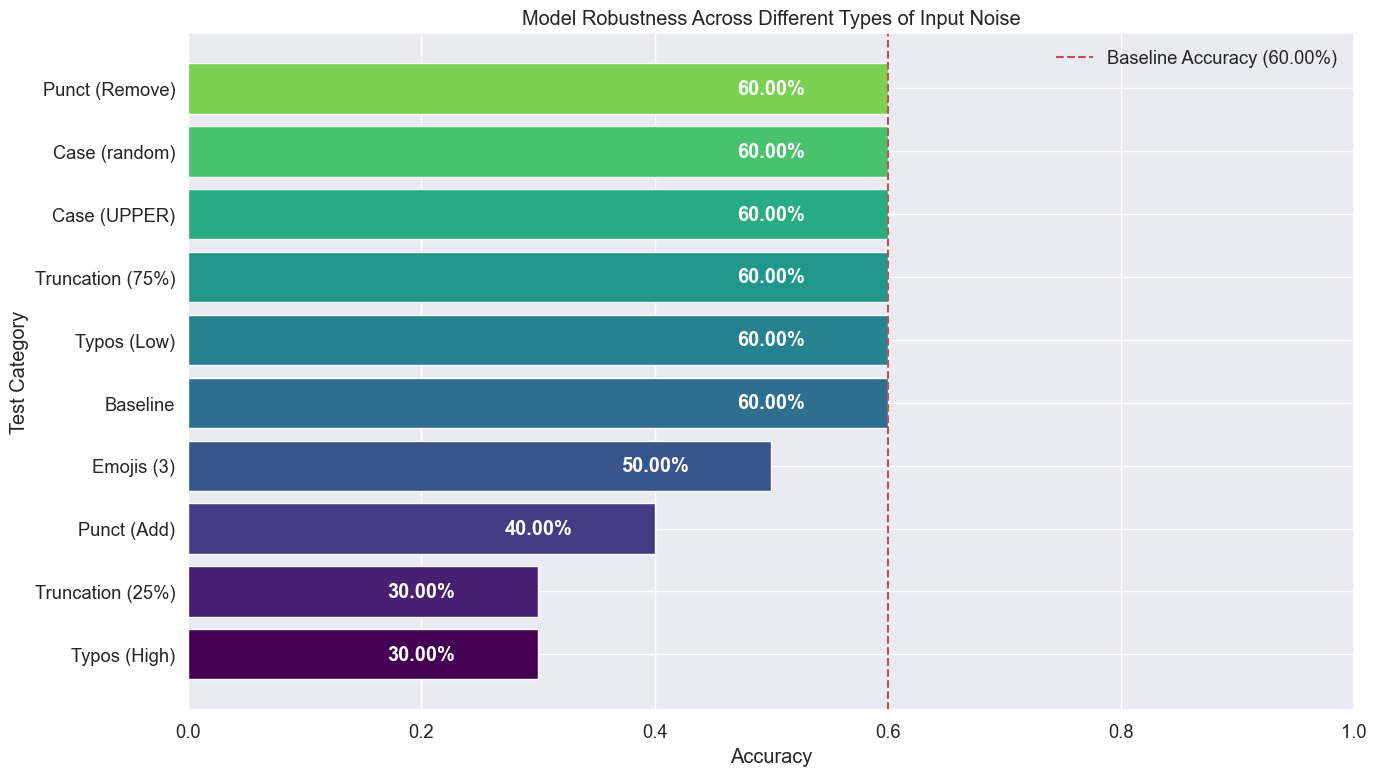

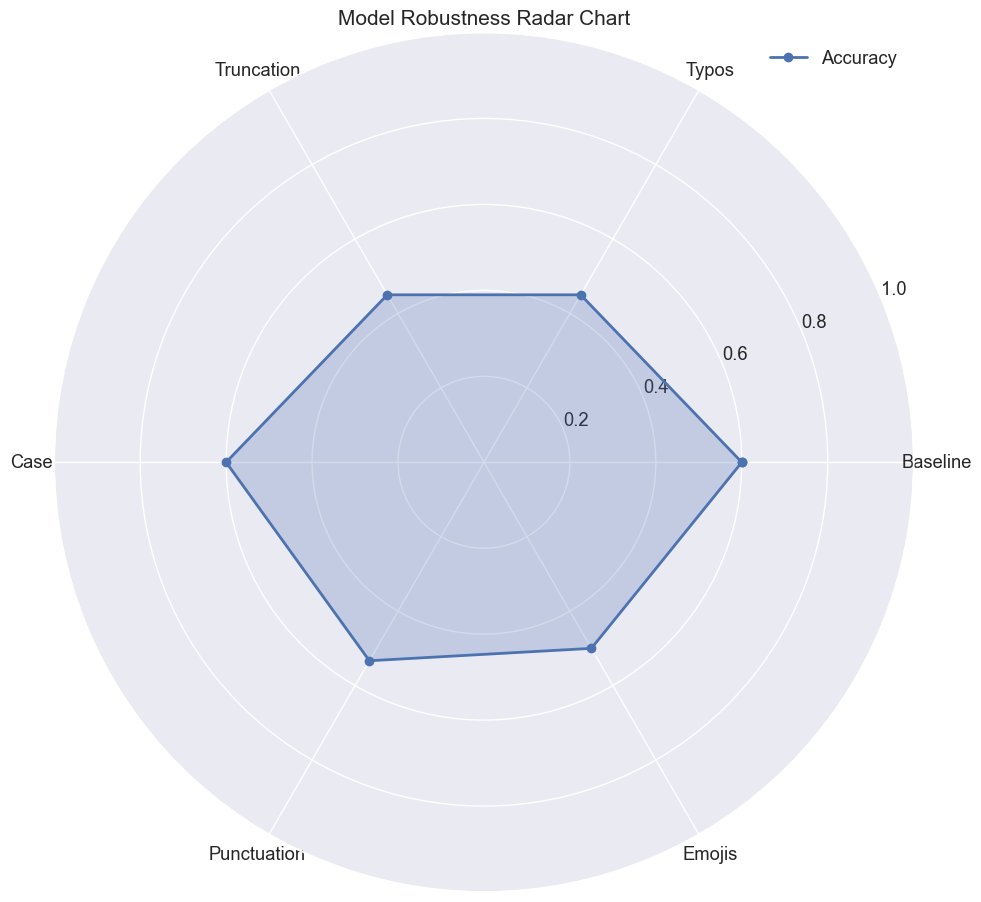

,Category,Accuracy,Drop from Baseline,Drop %,Robustness Score
0,Baseline,60.00%,0.00%,0.0%,High
1,Typos (Low),60.00%,0.00%,0.0%,High
4,Truncation (75%),60.00%,0.00%,0.0%,High
5,Case (UPPER),60.00%,0.00%,0.0%,High
6,Case (random),60.00%,0.00%,0.0%,High
7,Punct (Remove),60.00%,0.00%,0.0%,High
9,Emojis (3),50.00%,10.00%,16.7%,Medium
8,Punct (Add),40.00%,20.00%,33.3%,Low
2,Typos (High),30.00%,30.00%,50.0%,Low
3,Truncation (25%),30.00%,30.00%,50.0%,Low



=== ROBUSTNESS ANALYSIS SUMMARY ===

Based on the test results, the model's robustness varies across different types of noise:
• LEAST ROBUST to: Typos (High) (accuracy: 30.00%)
• MOST ROBUST to: Typos (Low), Truncation (75%), Case (UPPER), Case (random), Punct (Remove)

OVERALL ROBUSTNESS: GOOD
Average accuracy across all noise types: 50.00%
Average drop from baseline: 10.00%

RECOMMENDATIONS:
• Focus on improving robustness to Typos (High) as highest priority

This robustness testing provides a comprehensive view of how the model performs under various real-world conditions where input text may contain noise, errors, or variations.


In [11]:
# Collect summary results from all tests
summary_results = {
    "Baseline": baseline_metrics["accuracy"],
    "Typos (Low)": typo_test_results["low"]["metrics"]["accuracy"],
    "Typos (High)": typo_test_results["high"]["metrics"]["accuracy"],
    "Truncation (25%)": truncation_test_results["25%"]["metrics"]["accuracy"],
    "Truncation (75%)": truncation_test_results["75%"]["metrics"]["accuracy"],
    "Case (UPPER)": case_test_results["upper"]["metrics"]["accuracy"],
    "Case (random)": case_test_results["random"]["metrics"]["accuracy"],
    "Punct (Remove)": punct_test_results["remove"]["medium"]["metrics"]["accuracy"],
    "Punct (Add)": punct_test_results["add"]["medium"]["metrics"]["accuracy"],
    "Emojis (3)": emoji_test_results["3_emojis"]["metrics"]["accuracy"],
}

# Sort the results by accuracy
sorted_results = {k: v for k, v in sorted(summary_results.items(), key=lambda item: item[1])}
categories = list(sorted_results.keys())
accuracies = list(sorted_results.values())

# Create a bar chart of all test results
plt.figure(figsize=(14, 8))
bars = plt.barh(categories, accuracies, color=plt.cm.viridis(np.linspace(0, 0.8, len(categories))))
plt.axvline(x=baseline_metrics["accuracy"], color='r', linestyle='--', 
           label=f'Baseline Accuracy ({baseline_metrics["accuracy"]:.2%})')
plt.xlabel('Accuracy')
plt.ylabel('Test Category')
plt.title('Model Robustness Across Different Types of Input Noise')
plt.xlim(0, 1.0)

# Add values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(max(0.02, width - 0.1), bar.get_y() + bar.get_height()/2.,
             f'{width:.2%}', ha='center', va='center', color='white', fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

# Create a radar chart to visualize different dimensions of robustness
categories = ["Baseline", "Typos", "Truncation", "Case", "Punctuation", "Emojis"]
values = [
    baseline_metrics["accuracy"],
    (typo_test_results["low"]["metrics"]["accuracy"] + typo_test_results["high"]["metrics"]["accuracy"]) / 2,
    (truncation_test_results["25%"]["metrics"]["accuracy"] + truncation_test_results["75%"]["metrics"]["accuracy"]) / 2,
    (case_test_results["upper"]["metrics"]["accuracy"] + case_test_results["random"]["metrics"]["accuracy"]) / 2,
    (punct_test_results["remove"]["medium"]["metrics"]["accuracy"] + 
     punct_test_results["add"]["medium"]["metrics"]["accuracy"] +
     punct_test_results["replace"]["medium"]["metrics"]["accuracy"]) / 3,
    emoji_test_results["3_emojis"]["metrics"]["accuracy"]
]

# Set up the radar chart
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the loop
values += values[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, values, 'o-', linewidth=2, label="Accuracy")
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1)
ax.grid(True)
ax.set_title("Model Robustness Radar Chart", size=15)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Create summary table of results
summary_data = []
for category, accuracy in summary_results.items():
    # Calculate drop from baseline
    drop = baseline_metrics["accuracy"] - accuracy
    drop_percent = (drop / baseline_metrics["accuracy"]) * 100
    
    summary_data.append({
        "Category": category,
        "Accuracy": f"{accuracy:.2%}",
        "Drop from Baseline": f"{drop:.2%}",
        "Drop %": f"{drop_percent:.1f}%",
        "Robustness Score": "High" if drop < 0.05 else ("Medium" if drop < 0.15 else "Low")
    })

# Convert to DataFrame for nice display
summary_df = pd.DataFrame(summary_data)
display(summary_df.sort_values("Drop from Baseline"))

# Final conclusions
print("\n=== ROBUSTNESS ANALYSIS SUMMARY ===\n")
print("Based on the test results, the model's robustness varies across different types of noise:")

# Find the most and least robust categories
min_accuracy_cat = min(summary_results.items(), key=lambda x: x[1])
max_accuracy_cat = max(summary_results.items(), key=lambda x: x[1])

if min_accuracy_cat[0] != "Baseline":
    print(f"• LEAST ROBUST to: {min_accuracy_cat[0]} (accuracy: {min_accuracy_cat[1]:.2%})")
    
most_robust = [k for k, v in summary_results.items() 
               if v > baseline_metrics["accuracy"] - 0.05 and k != "Baseline"]
if most_robust:
    print(f"• MOST ROBUST to: {', '.join(most_robust)}")

# Overall assessment
avg_non_baseline = np.mean([v for k, v in summary_results.items() if k != "Baseline"])
robustness_drop = baseline_metrics["accuracy"] - avg_non_baseline

if robustness_drop < 0.05:
    overall = "EXCELLENT"
elif robustness_drop < 0.1:
    overall = "GOOD"
elif robustness_drop < 0.2:
    overall = "MODERATE"
else:
    overall = "POOR"
    
print(f"\nOVERALL ROBUSTNESS: {overall}")
print(f"Average accuracy across all noise types: {avg_non_baseline:.2%}")
print(f"Average drop from baseline: {robustness_drop:.2%}")

print("\nRECOMMENDATIONS:")
if overall in ["POOR", "MODERATE"]:
    print("• Consider data augmentation with noise during training")
    print("• Implement preprocessing to handle common noise types")
    print("• Deploy a text normalization layer before sentiment analysis")
    
if min_accuracy_cat[1] < baseline_metrics["accuracy"] * 0.7:
    print(f"• Focus on improving robustness to {min_accuracy_cat[0]} as highest priority")

print("\nThis robustness testing provides a comprehensive view of how the model performs under various real-world conditions where input text may contain noise, errors, or variations.")